# Part 1: Fine-Tune YOLOv12 for python3 -m pip install nvidia-cuda-runtime-cu12 vehicle Detection

This notebook part demonstrates how to fine-tune the YOLOv12 object detection model on a custom dataset of hard-hat-detection. We'll go through environment setup, training, evaluation, and inference steps.

## Environment setup

### Step 1: Install Dependencies

We install the required packages:
- `ultralytics`: Official package to use YOLO models including the new YOLOv12.
- `supervision`: A toolset for evaluating and visualizing object detection results.

In [ ]:
!pip install ultralytics supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.2 MB/s eta 0:00:00


### Step 2: Check GPU Availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sun Nov  9 05:37:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Step 3: Set Working Directory

This sets up the current working directory and store in a variable for use later when accessing files or saving models, and prints it for confirmation.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Step 4: Prepare the Dataset

Instructions:
1.	Go to Google Drive of this hands-on, and copy the dataset ZIP file (rock-paper-scissors-14.zip) into your My Drive.
You can place it under a new folder named datasets or directly under My Drive.
2.	In the left sidebar of Colab, go to the Files tab (📁 icon), and click “Mount Drive”.
3.	Once mounted, your Google Drive will be available under the path: /content/drive/MyDrive/.
4.	Find the path to your dataset file (right-click → Copy path).
5.	Replace the SOURCE PATH below with your copied path, then copy it into your working directory and unzip:

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy the dataset ZIP to the current working directory
!scp -r /content/drive/MyDrive/Capstone4/vehicle-detection.v1i.yolov12.zip . # REPLACE THE SOURCE PATH WITH YOURS -> /content/drive/MyDrive/datasets/rock-paper-scissors-14.zip

Mounted at /content/drive


Unzips the dataset containing labeled images for person with hard hat and with no hard hat

In [ ]:
# Unzip the dataset
!unzip /content/drive/MyDrive/Capstone4/vehicle-detection.v1i.yolov12.zip -d /content/content

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/train/labels/Screenshot-2025-04-07-215645_png.rf.41ea7ce664e052543505dc89c696e939.txt  
  inflating: /content/content/train/labels/Screenshot-2025-04-07-215645_png.rf.cafdb8b739000d563e63a3f879b77afd.txt  
  inflating: /content/content/train/labels/Screenshot-2025-04-07-215649_png.rf.81f7918ce7f35393d074d28432d213fc.txt  
  inflating: /content/content/train/labels/Screenshot-2025-04-07-215649_png.rf.892742101908a1d569db1f50605192b0.txt  
  inflating: /content/content/train/labels/Screenshot-2025-04-07-215649_png.rf.917687f765b532174bdd19a7f68e46d9.txt  
  inflating: /content/content/train/labels/Screenshot-2025-04-07-215704_png.rf.6b7dba37287abf9e21c6b40047a4bdc1.txt  
  inflating: /content/content/train/labels/Screenshot-2025-04-07-215704_png.rf.bbfc45ff62361c03436e6044a4c08e89.txt  
  inflating: /content/content/train/labels/Screenshot-2025-04-07-215704_png.rf.e5a16065a1220994548a25ba0260f4a4.txt  
  inf

### Step 5: Dataset Overview

- Sets dataset location in a variable.
- Lists the contents of the dataset.
- Displays the data.yaml configuration file.

`data.yaml` tells YOLO where to find training/validation images, and which class labels are being used.


In [ ]:
dataset_location = "/content/content"

In [ ]:
!ls {dataset_location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
!cat {dataset_location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['bus', 'car', 'van']

roboflow:
  workspace: personal-project-kej16
  project: vehicle-detection-vznzd-dkl8g
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/personal-project-kej16/vehicle-detection-vznzd-dkl8g/dataset/1

### Step 6: Download Pretrained YOLOv12 Weights

Downloads a pretrained YOLOv12 nano model (`yolov12n.pt`) to be fine-tuned.

In [ ]:
!wget https://github.com/sunsmarterjie/yolov12/releases/download/v1.0/yolov12n.pt

--2025-11-09 05:38:54--  https://github.com/sunsmarterjie/yolov12/releases/download/v1.0/yolov12n.pt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/928546208/99db71db-0946-4c10-94a0-b54baf471037?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-09T06%3A35%3A03Z&rscd=attachment%3B+filename%3Dyolov12n.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-09T05%3A34%3A51Z&ske=2025-11-09T06%3A35%3A03Z&sks=b&skv=2018-11-09&sig=ircfDLzHo%2BLEteB0nJG%2Bnq%2FOQhef%2FHUtEyaC3xfJTZc%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MjY2NzAzNCwibmJmIjoxNzYyNjY2NzM0LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi

### Step 7: Load Pretrained YOLO Model

Initializes the YOLO model using the downloaded weights.

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Step 8: Train the Model

Fine-tune YOLOv12 using our dataset for 20 epochs.
Parameters include:
- `data`: path to YAML config
- `epochs`: total number of training epochs
- `batch`: number of images per batch
- `imgsz`: input image size
- `patience`: early stopping if no improvement
- `save_period`: save model checkpoint every 5 epochs
- `val`: whether to validate

Trains YOLOv12 model on your dataset and saves it under runs/detect/train.


In [ ]:
results = model.train(
        data=f'{dataset_location}/data.yaml', # Using 10 epochs for faster training
        epochs=20,
        batch=16,
        imgsz=640,
        exist_ok=True,
        x_lambda=5.0,

        patience=5,              # Early stopping if no improvement for 5 epochs
        save_period=5,           # Save checkpoints every 5 epochs
        val=True,                # Ensure validation is performed
        verbose=True,            # Show detailed output during training
)

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0,

## Evaluation

### Step 9: Post-training Setup

Fix for character encoding and display directory structure for output artifacts.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Lists training artifacts such as weights, result plots, and confusion matrix.
!ls {HOME}/runs/detect/train/

args.yaml			 results.csv	      val_batch0_labels.jpg
BoxF1_curve.png			 results.png	      val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
BoxPR_curve.png			 train_batch1.jpg     val_batch1_pred.jpg
BoxR_curve.png			 train_batch2.jpg     val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch5770.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch5771.jpg  weights
labels.jpg			 train_batch5772.jpg


### Step 10: Visualize Training Results

Display the confusion matrix and training result curves from the YOLO training run. The confusion matrix: how well the model distinguishes between classes.

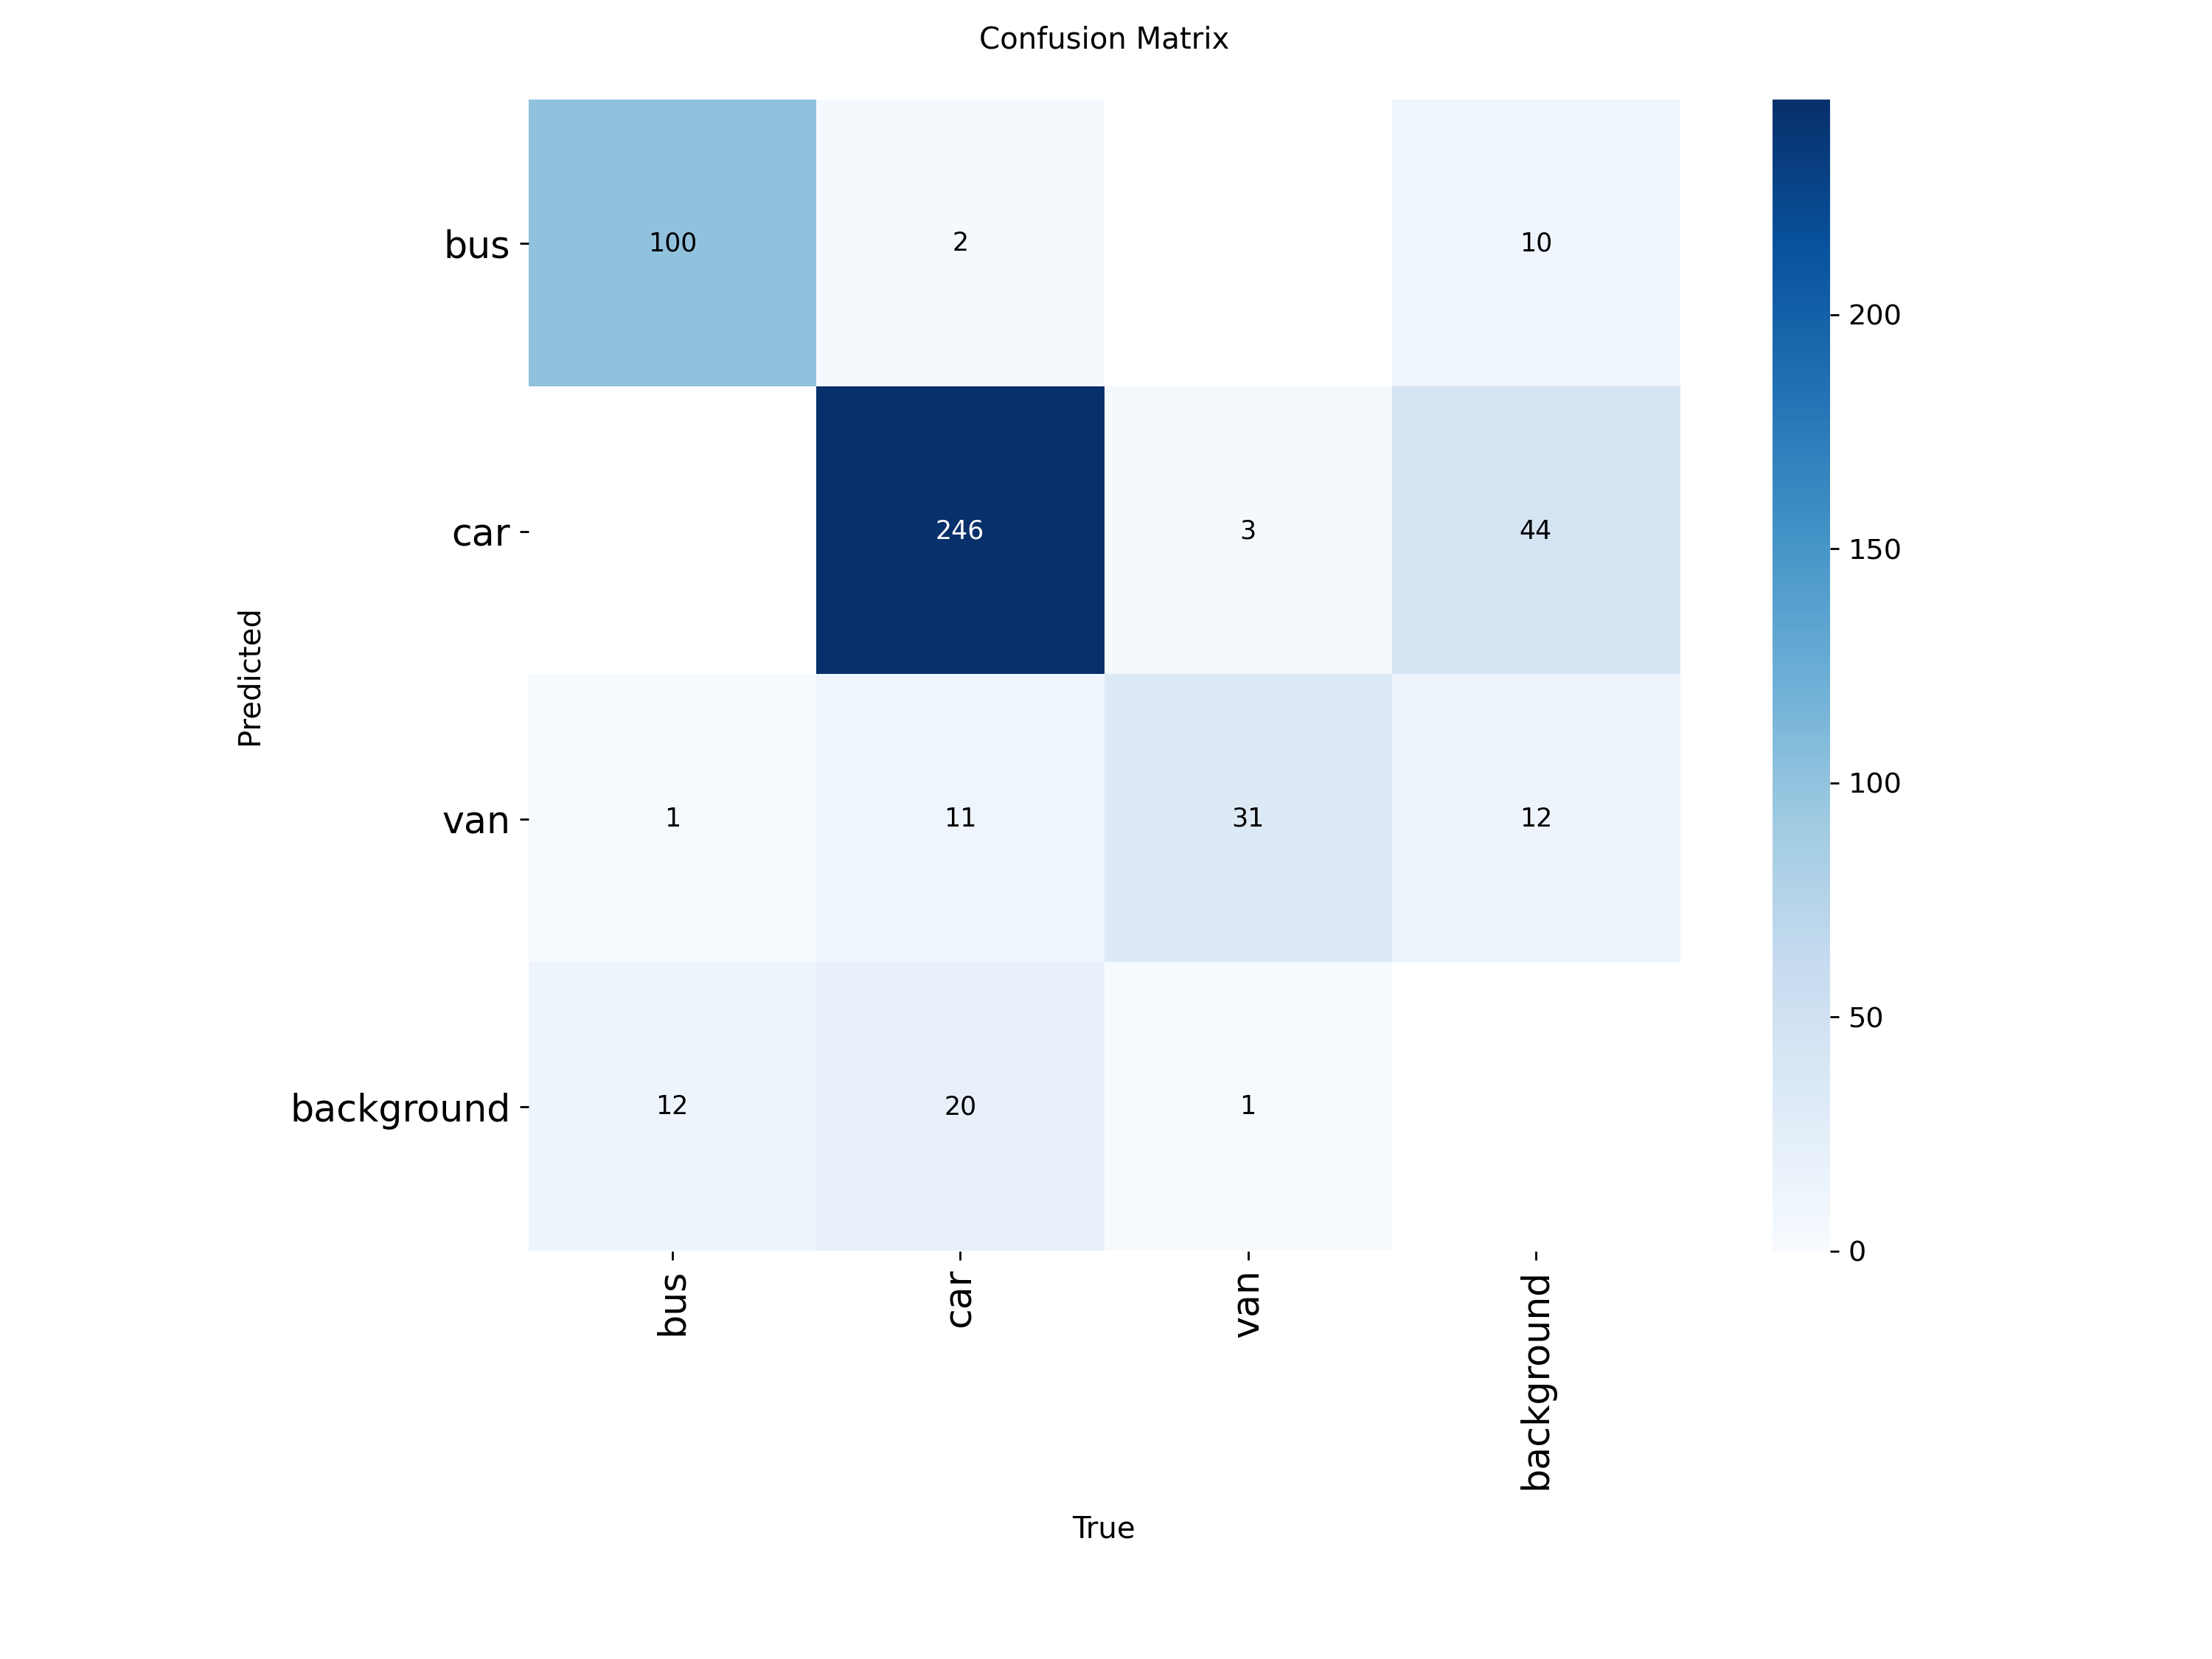

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

The training graph: loss, mAP, precision/recall over time.

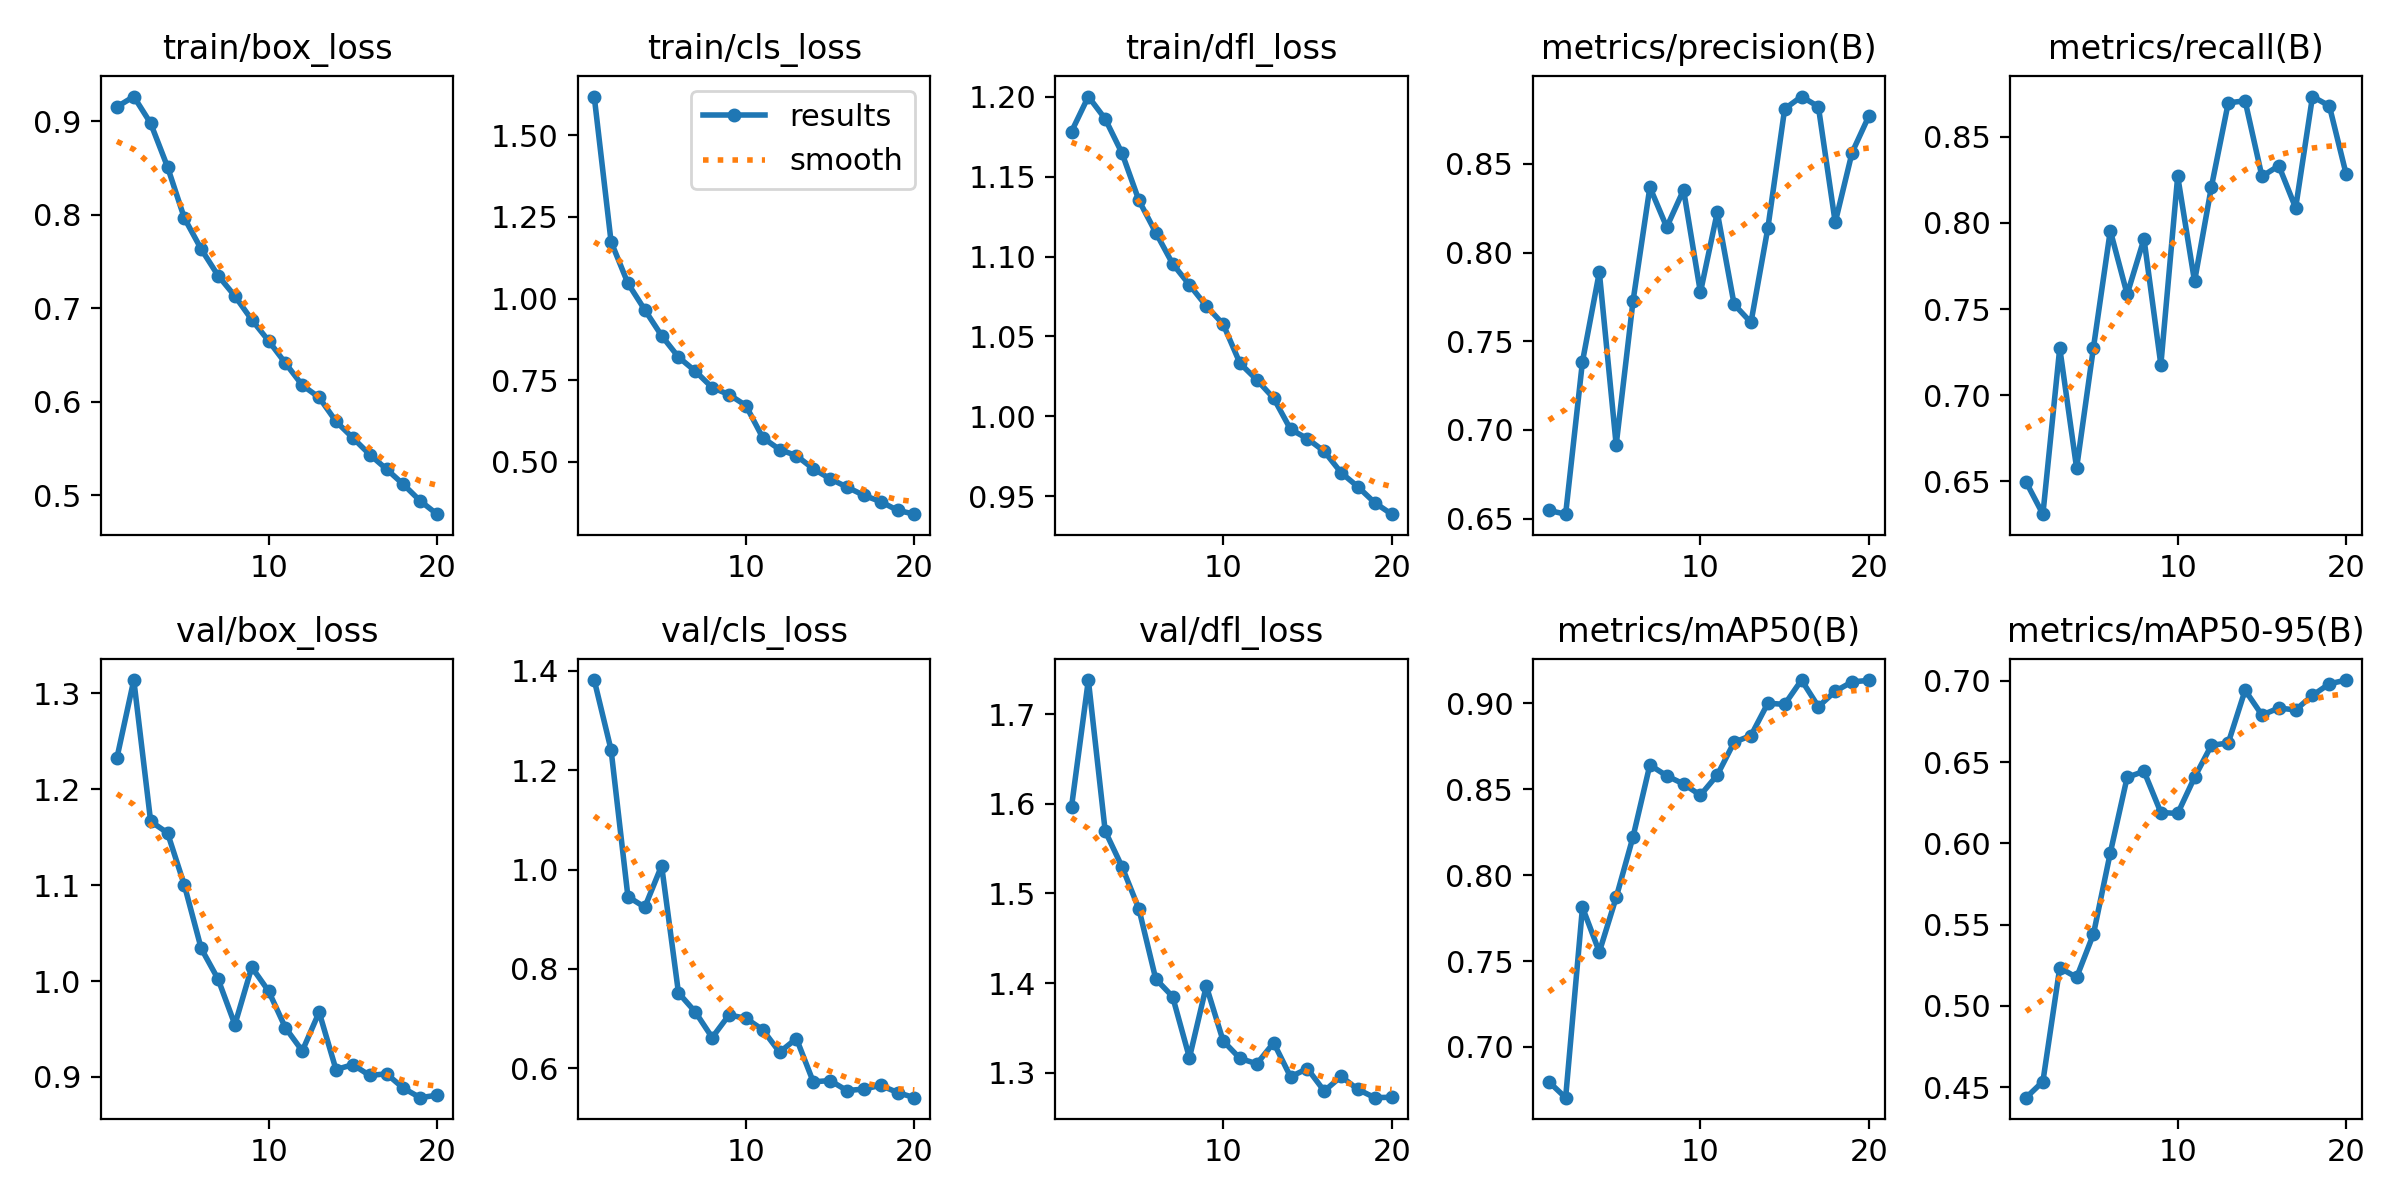

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

### Step 11: Load Test Dataset for Evaluation

Prepare test data using Supervision's dataset loader to evaluate model performance.

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

ds.classes

['bus', 'car', 'van']

### Step 12: Compute Mean Average Precision

Evaluate the trained model using mAP metrics (50, 75, and 50:95).

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

The mAP metrics are printed and the results are plotted.

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6447584433382982
mAP 50 0.7987613764504652
mAP 75 0.730713692260938


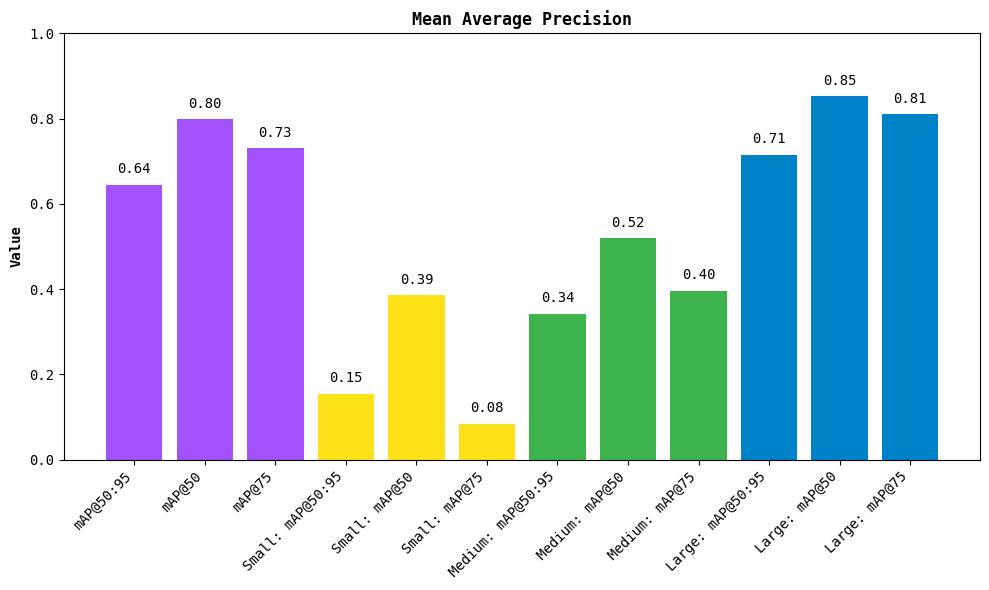

In [ ]:
map.plot()

### Step 13: Inference on Random Test Image

Run the trained model on a random test image and visualize detections.

In [ ]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

- Picks a random image.
- Runs the trained YOLOv12 model.
- Applies NMS (Non-Max Suppression) to clean overlapping boxes.

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

`plot_image` displays the final annotated image with predicted bounding boxes and labels.

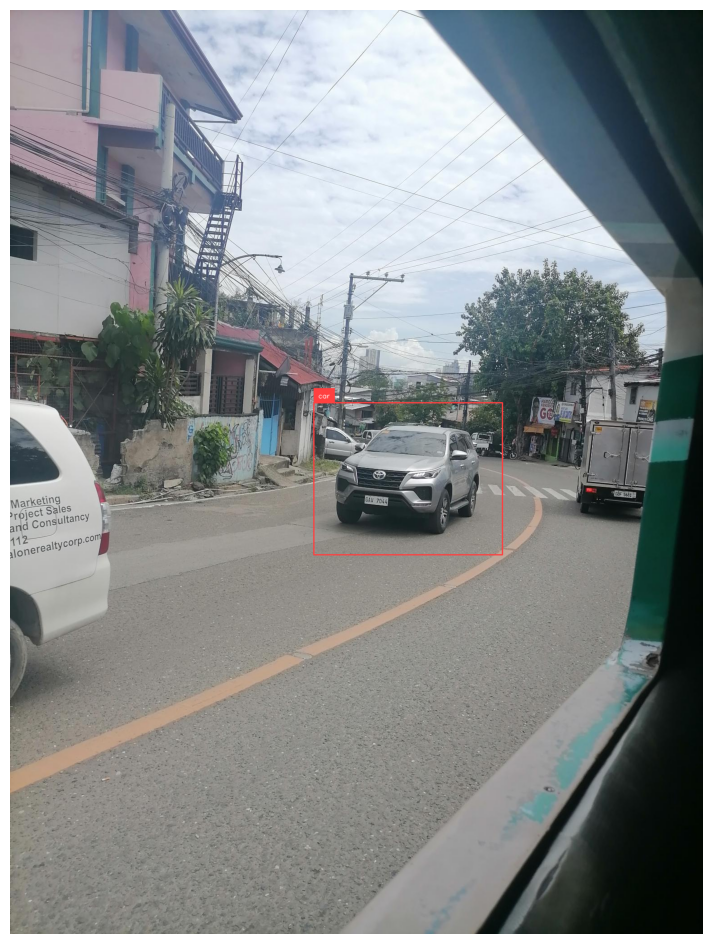

In [ ]:
sv.plot_image(annotated_image)

# Part 2: Gradio Simulation for License Plate Detection + Crop

In [ ]:
import gradio as gr
from ultralytics import YOLO
import numpy as np
import cv2
from PIL import Image
from collections import Counter

In [ ]:
# Load model
model = YOLO("/content/runs/detect/train/weights/best.pt")

class_names = ["bus", "car","van"]

In [ ]:
# Global counter dashboard
global_stats = {"bus": 0, "car": 0,"van":0}
def detect_hardhat(image):
    results = model.predict(source=image, save=False, conf=0.3)[0]
    image_np = np.array(image)
    annotated_img = image_np.copy()

    session_counter = Counter()

    for box in results.boxes:
        cls_id = int(box.cls.item())
        label = class_names[cls_id]
        conf = float(box.conf.item())
        coords = box.xyxy.cpu().numpy().astype(int)[0]
        x1, y1, x2, y2 = coords

        color = (0, 200, 0) if label == "car" else (0, 0, 255)
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(annotated_img, f"{label} ({conf:.2f})", (x1, y1 - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        session_counter[label] += 1
        global_stats[label] += 1

    # Generate detection status
    if session_counter["bus"] > 0:
        status_html = (
            "<div style='padding:10px; background-color:#ffe5e5; color:#a30000; "
            "border-left: 6px solid #f00; font-weight:bold;'>⚠️ Detected as bus </div>"
        )
    elif session_counter["car"] > 0:
        status_html = (
            "<div style='padding:10px; background-color:#e6ffe6; color:#006600; "
            "border-left: 6px solid #0f0; font-weight:bold;'>✅ Detected as A car.</div>"
        )
    elif session_counter["van"]> 0:
          status_html=(
            "<div style='padding:10px; background-color:#e6ffe6; color:#006600; "
            "border-left: 6px solid #0f0; font-weight:bold;'>✅ Detected as A van.</div>"
          )
    else:
        status_html = (
            "<div style='padding:10px; background-color:#fff3cd; color:#856404; "
            "border-left: 6px solid #ffcc00; font-weight:bold;'>⚠️ No vehicle detected.</div>"
        )

    dashboard_html = (
        f"<div style='padding:10px; background-color:#f4f4f4; border:1px solid #ccc; border-radius:6px;'>"
        f"<b>📊 Global Dashboard (Session Total):</b><br>"
        f"🟢 bus: <b>{global_stats['bus']}</b><br>"
        f"🔴 car: <b>{global_stats['car']}</b><br>"
        f"🔴 van: <b>{global_stats['van']}</b><br>"
        f"</div>"
    )

    return Image.fromarray(annotated_img), status_html, dashboard_html

In [ ]:
# Gradio UI
import gradio as gr # Added import for gradio

with gr.Blocks() as demo:
    gr.Markdown("## 🛠️ Vehicale Detection System")
    gr.Markdown("Upload a photo of a work site to detect if people are wearing hard hats.")

    with gr.Row():
        with gr.Column():
            input_image = gr.Image(type="pil", label="Upload Image")
            detect_btn = gr.Button("🔍 Vehicale")
        with gr.Column():
            output_image = gr.Image(type="pil", label="Detection Result")
            detection_status = gr.HTML(label="Detection Status")
            dashboard_panel = gr.HTML(label="Cumulative Safety Dashboard")

    detect_btn.click(
        fn=detect_hardhat,
        inputs=input_image,
        outputs=[output_image, detection_status, dashboard_panel]
    )

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ab9386ebb91fcbcd1b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
